In [1]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import json 
import os
import glob
import PIL.Image as Image
import copy
import time
import shutil
import tqdm

from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

import selectivesearch

### Load data

#### Change project directory and run once

In [2]:
# Create directories
data_path='/dtu/datasets1/02514/data_wastedetection'
project_path = os.path.join(os.getcwd(), 'Project1.2')
os.mkdir(os.path.join(project_path, 'data'))
os.mkdir(os.path.join(project_path, 'data', 'raw'))
os.mkdir(os.path.join(project_path, 'data', 'splitted'))
os.mkdir(os.path.join(project_path, 'data', 'raw', 'test'))
os.mkdir(os.path.join(project_path, 'data', 'raw', 'train'))
os.mkdir(os.path.join(project_path, 'data', 'splitted', 'train'))
os.mkdir(os.path.join(project_path, 'data', 'splitted', 'test'))
os.mkdir(os.path.join(project_path, 'data', 'splitted', 'train', 'Background'))
os.mkdir(os.path.join(project_path, 'data', 'splitted', 'test', 'Background'))

annotations = json.load(open(os.path.join('Project1.2/annotations.json')))
supercategories = {}
categories = ['Background']
for i in range(len(annotations['categories'])):
    supercategories[str(i)] = annotations['categories'][i]['supercategory']
    if annotations['categories'][i]['supercategory'] not in categories:
        categories.append(annotations['categories'][i]['supercategory'])
        os.mkdir(os.path.join(project_path, 'data', 'splitted', 'train', annotations['categories'][i]['supercategory']))
        os.mkdir(os.path.join(project_path, 'data', 'splitted', 'test', annotations['categories'][i]['supercategory']))

In [3]:
annotations = json.load(open(os.path.join('Project1.2/annotations.json')))
supercategories = {}
categories = ['Background']
for i in range(len(annotations['categories'])):
    supercategories[str(i)] = annotations['categories'][i]['supercategory']
    if annotations['categories'][i]['supercategory'] not in categories:
        categories.append(annotations['categories'][i]['supercategory'])

In [3]:
for id in range(len(annotations['images'])):
    if int(annotations['images'][id]['file_name'].split('_')[1].split('/')[0]) < 13:
        shutil.copyfile(os.path.join(data_path, annotations['images'][id]['file_name']), os.path.join(project_path, 'data', 'raw', 'train', str(id)+'.jpg'))
    else:
        shutil.copyfile(os.path.join(data_path, annotations['images'][id]['file_name']), os.path.join(project_path, 'data', 'raw', 'test', str(id)+'.jpg'))

In [18]:
# def get_iou(bb1, bb2):
#     # assert bb1[0] < bb1[2]
#     # assert bb1[1] < bb1[3]
#     # assert bb2[0] < bb2[2]
#     # assert bb2[1] < bb2[3]
#     x_left = max(bb1[0], bb2[0])
#     y_top = max(bb1[1], bb2[1])
#     x_right = min(bb1[2], bb2[2])
#     y_bottom = min(bb1[3], bb2[3])
#     if x_right < x_left or y_bottom < y_top:
#         return 0.0
#     intersection_area = (x_right - x_left) * (y_bottom - y_top)
#     bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
#     bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
#     iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
#     if iou < 0.0 or iou > 1.0:
#         return 0.0
#     return iou

def get_iou(box1, box2):
    """ 
        We assume that the box follows the format:
        box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
        where (x1,y1) and (x3,y3) represent the top left coordinate,
        and (x2,y2) and (x4,y4) represent the bottom right coordinate 
    
        Parameters
        ----------
        
        box1: The coordinates of the first box
        box2: The coordinates of the first box
        threshold: The boundary threshold

        Returns
        -------
    """
    x1, y1, x2, y2 = box1	
    x3, y3, x4, y4 = box2
    x_inter1 = max(x1, x3)
    y_inter1 = max(y1, y3)
    x_inter2 = min(x2, x4)
    y_inter2 = min(y2, y4)
    if x_inter2 <= x_inter1 or y_inter2 <= y_inter1:
        return 0.0
    width_inter = abs(x_inter2 - x_inter1)
    height_inter = abs(y_inter2 - y_inter1)
    area_inter = width_inter * height_inter
    width_box1 = abs(x2 - x1)
    height_box1 = abs(y2 - y1)
    width_box2 = abs(x4 - x3)
    height_box2 = abs(y4 - y3)
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    area_union = area_box1 + area_box2 - area_inter
    iou_res = area_inter / area_union
    return  iou_res

def resize(image, BB, size=1000, aspect=True):
    ### resize image
    if aspect:
        if image.shape[1] > image.shape[0]:
            size = (size, int(size*image.shape[0]/image.shape[1]))
        else:
            size = (int(size*image.shape[1]/image.shape[0]), size)
    else:
        size = (size, size)

    img_resized = cv2.resize(image.copy(), size, interpolation = cv2.INTER_AREA)
            
    ### resize BB
    # get x and y ratio
    lx = size[0]/image.shape[1]
    ly = size[1]/image.shape[0]
    
    # get new (x,y), width, height
    BB_new = [int(BB[0]*lx), int(BB[1]*ly), int(BB[2]*lx), int(BB[3]*ly)]
    
    return img_resized, BB_new

def edgeBoxDetection(image):
    proposals = np.array([])
    model = os.path.join(os.getcwd(), 'Project1.2', 'model.yml')
    edge_detection = cv2.ximgproc.createStructuredEdgeDetection(model)
    edges = edge_detection.detectEdges(np.float32(image) / 255.0)

    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap)

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(200)
    boxes = edge_boxes.getBoundingBoxes(edges, orimap)

    return boxes[0]

In [5]:
# Create image correspondance with annotations
image_annot_correspondance = {}
for image_id in range(1500):
    image_annot_correspondance[str(image_id)] = []
    for annotation_id in range(len(annotations['annotations'])):
        if int(annotations['annotations'][annotation_id]['image_id']) == image_id:
            image_annot_correspondance[str(image_id)].append(annotation_id+1)
image_annot_correspondance

{'0': [1],
 '1': [2, 3],
 '2': [4, 5],
 '3': [6, 7, 8, 9],
 '4': [10],
 '5': [11, 12, 13, 14, 15, 16],
 '6': [17],
 '7': [18, 19],
 '8': [20],
 '9': [21, 22, 23],
 '10': [24, 25],
 '11': [26, 27, 28, 29, 30, 31],
 '12': [32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
 '13': [42, 43, 44, 45],
 '14': [46],
 '15': [47, 48, 49],
 '16': [50, 51],
 '17': [52],
 '18': [53],
 '19': [54, 55],
 '20': [56, 57, 58, 59],
 '21': [60, 61],
 '22': [62, 63],
 '23': [64, 65, 66, 67],
 '24': [68],
 '25': [69, 70],
 '26': [71, 72],
 '27': [73, 74, 75, 76, 77, 78, 79],
 '28': [80, 81, 82],
 '29': [83],
 '30': [84, 283],
 '31': [85],
 '32': [86],
 '33': [87, 88, 89, 90],
 '34': [91, 92],
 '35': [93, 94, 95, 96],
 '36': [97],
 '37': [98],
 '38': [99, 100],
 '39': [101],
 '40': [102],
 '41': [103, 104, 105],
 '42': [106],
 '43': [107, 108, 109],
 '44': [110, 111, 112, 113, 114],
 '45': [115, 116, 117, 118, 119, 120],
 '46': [121, 122, 123, 124, 125, 126],
 '47': [127, 128, 129, 130],
 '48': [131],
 '49': [132],
 '5

In [6]:
supercategories

{'0': 'Aluminium foil',
 '1': 'Battery',
 '2': 'Blister pack',
 '3': 'Blister pack',
 '4': 'Bottle',
 '5': 'Bottle',
 '6': 'Bottle',
 '7': 'Bottle cap',
 '8': 'Bottle cap',
 '9': 'Broken glass',
 '10': 'Can',
 '11': 'Can',
 '12': 'Can',
 '13': 'Carton',
 '14': 'Carton',
 '15': 'Carton',
 '16': 'Carton',
 '17': 'Carton',
 '18': 'Carton',
 '19': 'Carton',
 '20': 'Cup',
 '21': 'Cup',
 '22': 'Cup',
 '23': 'Cup',
 '24': 'Cup',
 '25': 'Food waste',
 '26': 'Glass jar',
 '27': 'Lid',
 '28': 'Lid',
 '29': 'Other plastic',
 '30': 'Paper',
 '31': 'Paper',
 '32': 'Paper',
 '33': 'Paper',
 '34': 'Paper bag',
 '35': 'Paper bag',
 '36': 'Plastic bag & wrapper',
 '37': 'Plastic bag & wrapper',
 '38': 'Plastic bag & wrapper',
 '39': 'Plastic bag & wrapper',
 '40': 'Plastic bag & wrapper',
 '41': 'Plastic bag & wrapper',
 '42': 'Plastic bag & wrapper',
 '43': 'Plastic container',
 '44': 'Plastic container',
 '45': 'Plastic container',
 '46': 'Plastic container',
 '47': 'Plastic container',
 '48': 'Plast

In [8]:
path_train = os.path.join(os.getcwd(), 'Project1.2', 'data', 'raw', 'train')
size = 224
iou_threshold = 0.5

# patata_counter = 0
for image_name in tqdm(os.listdir(path_train)):
    # if patata_counter < 85: 
    #     patata_counter += 1
    #     continue
    image_id = int(image_name.split('.')[0])
    # print(patata_counter)
    
    path = os.path.join(path_train, image_name)
    image = cv2.imread(path)
    BB_proposals = edgeBoxDetection(image)

    true_images = []
    false_images = []

    counter = -1
    for proposal in BB_proposals:
        counter += 1
        proposed_images = []
        best = None
        for annotation in image_annot_correspondance[str(image_id)]:
            BB = [
                int(annotations['annotations'][annotation-1]['bbox'][0]),
                int(annotations['annotations'][annotation-1]['bbox'][1]),
                int(annotations['annotations'][annotation-1]['bbox'][0] + annotations['annotations'][annotation-1]['bbox'][2]), 
                int(annotations['annotations'][annotation-1]['bbox'][1] + annotations['annotations'][annotation-1]['bbox'][3])
                ]
            
            if counter == 1:
                try:
                    gt = image[BB[1]:BB[3], BB[0]:BB[2]]
                    cv2.imwrite(os.path.join(path_train.replace('raw', 'splitted'), supercategories[str(annotations['annotations'][annotation-1]['category_id'])], f'{image_id}.jpg'), gt)
                except:
                    continue
            proposal = [proposal[0], proposal[1], proposal[0]+proposal[2], proposal[1]+proposal[3]]
            iou = get_iou(BB, proposal)

            if best == None:
                best = [image[proposal[1]:proposal[3], proposal[0]:proposal[2]], iou, annotations['annotations'][annotation-1]['category_id']]
            elif best[1] < iou:
                best = [image[proposal[1]:proposal[3], proposal[0]:proposal[2]], iou, annotations['annotations'][annotation-1]['category_id']]

        if best[1] >= 0.5:
            true_images.append(best)
        elif best[1] < 0.3:
            false_images.append(best)

    write_counter = 0
    for true_id in range(len(true_images)):
        cv2.imwrite(os.path.join(path_train.replace('raw', 'splitted'), supercategories[str(true_images[true_id][2])], f'{image_id}_{write_counter}.jpg'), true_images[true_id][0])
        write_counter += 1

    false_num = int(3*len(true_images))
    print(len(true_images), len(false_images))
    for false_id in range(false_num):
        if false_id > len(false_images) -1 : break
        cv2.imwrite(os.path.join(path_train.replace('raw', 'splitted'), 'Background', f'{image_id}_{write_counter}.jpg'), false_images[false_id][0])
        write_counter += 1

  0%|          | 0/1215 [00:00<?, ?it/s]

/tmp/ipykernel_95442/657333794.py:14: RuntimeWarning: overflow encountered in int_scalars
  bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])


error: OpenCV(4.6.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [19]:
path_test = os.path.join(os.getcwd(), 'Project1.2', 'data', 'raw', 'test')
size = 224
iou_threshold = 0.5

patata_counter = 0
for image_name in tqdm(os.listdir(path_test)):
    if patata_counter < 162: 
        patata_counter += 1
        continue
    image_id = int(image_name.split('.')[0])
    print(patata_counter)
    
    path = os.path.join(path_test, image_name)
    image = cv2.imread(path)
    BB_proposals = edgeBoxDetection(image)

    true_images = []
    false_images = []

    counter = -1
    for proposal in BB_proposals:
        counter += 1
        proposed_images = []
        best = None
        for annotation in image_annot_correspondance[str(image_id)]:
            BB = [
                int(annotations['annotations'][annotation-1]['bbox'][0]),
                int(annotations['annotations'][annotation-1]['bbox'][1]),
                int(annotations['annotations'][annotation-1]['bbox'][0] + annotations['annotations'][annotation-1]['bbox'][2]), 
                int(annotations['annotations'][annotation-1]['bbox'][1] + annotations['annotations'][annotation-1]['bbox'][3])
                ]
            
            if counter == 1:
                try:
                    gt = image[BB[1]:BB[3], BB[0]:BB[2]]
                    cv2.imwrite(os.path.join(path_test.replace('raw', 'splitted'), supercategories[str(annotations['annotations'][annotation-1]['category_id'])], f'{image_id}.jpg'), gt)
                except:
                    continue
            proposal = [proposal[0], proposal[1], proposal[0]+proposal[2], proposal[1]+proposal[3]]
            iou = get_iou(BB, proposal)

            if best == None:
                best = [image[proposal[1]:proposal[3], proposal[0]:proposal[2]], iou, annotations['annotations'][annotation-1]['category_id']]
            elif best[1] < iou:
                best = [image[proposal[1]:proposal[3], proposal[0]:proposal[2]], iou, annotations['annotations'][annotation-1]['category_id']]

        if best[1] >= 0.5:
            true_images.append(best)
        elif best[1] < 0.3:
            false_images.append(best)

    write_counter = 0
    for true_id in range(len(true_images)):
        cv2.imwrite(os.path.join(path_test.replace('raw', 'splitted'), supercategories[str(true_images[true_id][2])], f'{image_id}_{write_counter}.jpg'), true_images[true_id][0])
        write_counter += 1

    false_num = int(3*len(true_images))
    print(len(true_images), len(false_images))
    for false_id in range(false_num):
        if false_id > len(false_images) -1 : break
        cv2.imwrite(os.path.join(path_test.replace('raw', 'splitted'), 'Background', f'{image_id}_{write_counter}.jpg'), false_images[false_id][0])
        write_counter += 1

  0%|          | 0/285 [00:00<?, ?it/s]

162
8 184
162
0 200
162
0 200
162
22 158
162
1 193
162
0 196
162
0 200
162


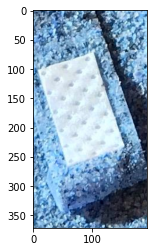

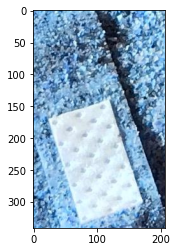

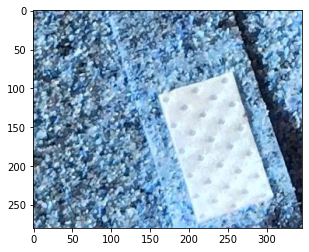

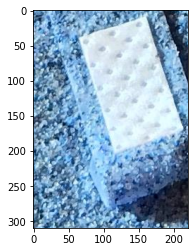

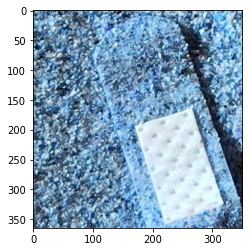

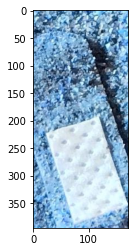

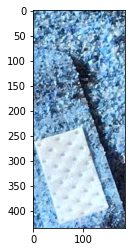

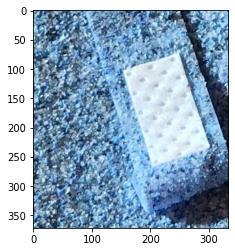

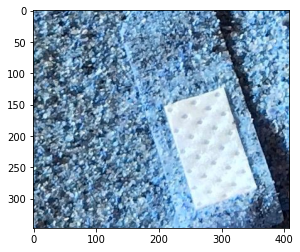

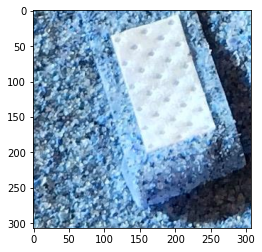

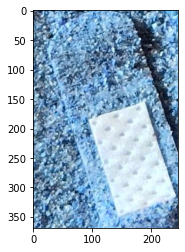

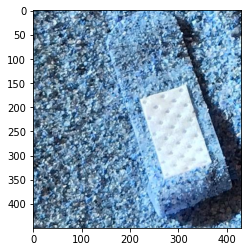

In [39]:
for image in proposed_images:
    if image[1] > 0.5:
        plt.imshow(image[0])
        plt.show()

#### Taco class

Image shape: (256, 256)


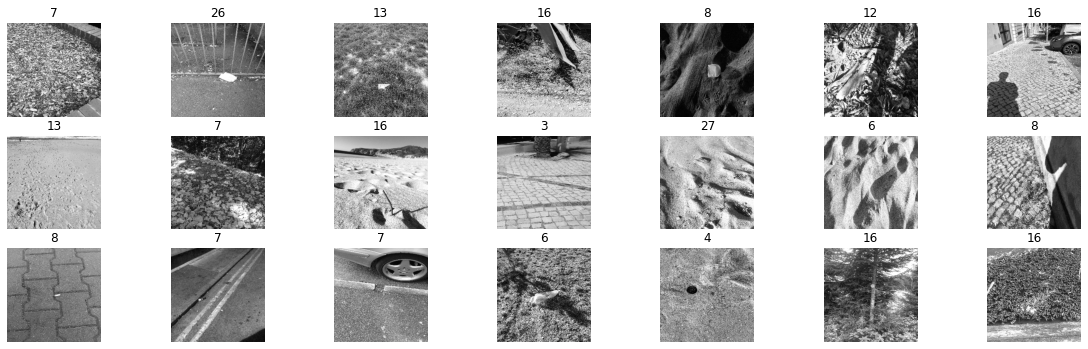

In [59]:
class Taco(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=os.path.join(os.getcwd(), 'Project1.2', 'data', 'splitted')):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

batch_size = 64

trans = transforms.Compose([ 
                            transforms.ToTensor(),
                            transforms.Resize((256, 256)),
                            ])

trainset = Taco(train=True, transform=trans)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Taco(train=False, transform=trans)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

print(f"Image shape: {images[0].numpy()[0].shape}")

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

In [ ]:
# Load annotations
annotations = json.load(open(os.path.join('Project1.2', 'annotations.json')))

In [ ]:
# Load images
data_path = '/dtu/datasets1/02514/data_wastedetection/'
images = {}
for image_id in range(len(annotations['images'])):
    images[image_id] = cv2.imread(os.path.join(data_path, annotations['images'][image_id]['file_name']))

In [ ]:
# Get bounding box for every image 
annotations['bounding_boxes'] = {}
for image_id in range(len(annotations['images'])):
    bbxstart = 10000
    bbxfin = 0
    bbystart = 10000
    bbyfin = 0
    for id, value in enumerate(annotations['annotations'][image_id]['segmentation'][0]):
        if id % 2 == 0:
            if bbxstart > value: bbxstart = value
            if bbxfin < value: bbxfin = value
        else:
            if bbystart > value: bbystart = value
            if bbyfin < value: bbyfin = value

    annotations['bounding_boxes'][image_id] = [int(bbxstart), int(bbystart), int(bbxfin), int(bbyfin)]

### Resize images and bounding boxes

In [1]:
os.getcwd()

NameError: name 'os' is not defined

In [ ]:
# # Resize images and bounding boxes
# resized_images = []
# annotations['new_bounding_boxes'] = {}
# for image_id in images:
    
#     # Resize images and bounding boxes
#     width = annotations['bounding_boxes'][image_id][2] - annotations['bounding_boxes'][image_id][0]
#     height = annotations['bounding_boxes'][image_id][3] - annotations['bounding_boxes'][image_id][1]
#     new_image, new_bb, new_width, new_height = resize(images[image_id], (annotations['bounding_boxes'][image_id][0], annotations['bounding_boxes'][image_id][1]), width, height)
    
#     # write resized images
#     resized_images.append(new_image)

#     # write new bounding boxes
#     annotations['new_bounding_boxes'][image_id] = [int(new_bb[0]), int(new_bb[1]), int(new_bb[0] + new_width), int(new_bb[1] + new_height)]